<a href="https://colab.research.google.com/github/rubenguerra/hello_world/blob/master/traductor_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  ##Version de tensorflow
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

TensorFlow 2.x selected.


In [2]:
#Se baja el archivo
path_to_zip = tf.keras.utils.get_file(
  'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+'/spa-eng/spa.txt'

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
#Convertir el archivo unicode a ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  
  #Se crea un espacio entre una palabra y el signo siguiente
  #ejemplo: 'he is a boy.' ==> 'he is a boy .'
  #Referencia: - https://stackoverflow.com/questions/3645931/python-padding-puntuation-with-white-spaces-keeping-puntuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  
  #Reemplaza cualquier signo por un espacio excepto (a-z, A-Z, '.', '?', '!', ',')
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  
  w = w.rstrip().strip()
  
  #Añade un comienzo y un final a la marca de la sentencia
  #Así el modelo sabe cuando empieza y termina
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
en_sentence = u'May I borrow this book?'
sp_sentence = u'¿Puedo tomar prestado este libro?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
#1.- Se remueven los acentos
#2.- Se limpian las sentencias
#3.- Regresa los pares de palabras en inglés , español

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().split('\n')
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  
  return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  
  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  #Creando entradas listas, pares de salida
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
  

In [0]:
#Se va a reducir el número de sentencias a usar por el tiempo, sólo se usarán 30000
#Se determina el numero de sentencias
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang =load_dataset(path_to_file, num_examples)

#Se calcula la máxima longitud del target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
#Se crea el conjunto de entrenamiento y validación usando el 80 y el 20% de la muestra
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

#Se muestra el tamaño de las muestras
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print('%d -----> %s' % (t, lang.index_word[t]))

In [14]:
print('Idioma de entrada; indice de palabras transformadas')
convert(inp_lang, input_tensor_train[0])
print()
print('Idioma de salida; indice de palabras transformadas')
convert(targ_lang, target_tensor_train[0])

Idioma de entrada; indice de palabras transformadas
1 -----> <start>
1658 -----> tomate
15 -----> un
1102 -----> descanso
3 -----> .
2 -----> <end>

Idioma de salida; indice de palabras transformadas
1 -----> <start>
94 -----> take
9 -----> a
516 -----> break
3 -----> .
2 -----> <end>


In [0]:
#Crea un conjunto de datos tf.data
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder= True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
    
    
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#Ejemplo de entrada
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
    
  def call(self, query, values):
    #Forma oculta == (batch_size, hidden_size)
    #Forma hidden_with_time_axis == (batch_size, 1, hidden size)
    #Se hace esto para desarrollar la adicion al calcular el escore
    hidden_with_times_axis = tf.expand_dims(query, 1)
    
    
    #Score shape == (batch_size, max_length, 1)
    #La forma del tensor despues de aplicar self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_times_axis)))
    
    attention_weights = tf.nn.softmax(score, axis=1)
    
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print('Forma del resultado de attention: (batch_size, units) {}'.format(attention_result.shape))
print('Forma del peso de attention: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

Forma del resultado de attention: (batch_size, units) (64, 1024)
Forma del peso de attention: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    #Usado por attention
    self.attention = BahdanauAttention(self.dec_units)
    
  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    
    output, state = self.gru(x)
    
    output = tf.reshape(output, (-1, output.shape[2]))
    
    x = self.fc(output)
    
    return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                     sample_hidden, sample_output)

print('Forma de la salida de Decoder: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))

Forma de la salida de Decoder: (batch_size, vocab_size) (64, 4935)


In [0]:
#Se definen el optimizador y la función de pérdida

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder = encoder,
                                decoder = decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    
    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      #pasando enc_output al decodificador (decoder)
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      
      loss += loss_function(targ[:, t], predictions)
      
      #usando teaching forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
      
  batch_loss = (loss / int(targ.shape[1]))
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, variables)
  
  optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss


      

In [26]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    
    if batch % 100 == 0:
      print('Epoca {} batch {} pérdida {:.4f}'.format(epoch + 1,
                                                      batch,
                                                     batch_loss.numpy()))
      
  # guardando (checkpoint) el modelo cada 2 epocas
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    
  print('Epoca {} pérdida {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
  
  print('Tiempo tomado por 1 epoca {} sec\n'.format(time.time() - start))

Epoca 1 batch 0 pérdida 4.5422
Epoca 1 batch 100 pérdida 2.2864
Epoca 1 batch 200 pérdida 1.8419
Epoca 1 batch 300 pérdida 1.7191
Epoca 1 pérdida 2.0208
Tiempo tomado por 1 epoca 36.414178133010864 sec

Epoca 2 batch 0 pérdida 1.5061
Epoca 2 batch 100 pérdida 1.4366
Epoca 2 batch 200 pérdida 1.3698
Epoca 2 batch 300 pérdida 1.2552
Epoca 2 pérdida 1.3529
Tiempo tomado por 1 epoca 26.945581912994385 sec

Epoca 3 batch 0 pérdida 1.0159
Epoca 3 batch 100 pérdida 0.8618
Epoca 3 batch 200 pérdida 0.8760
Epoca 3 batch 300 pérdida 0.7312
Epoca 3 pérdida 0.9219
Tiempo tomado por 1 epoca 26.259536266326904 sec

Epoca 4 batch 0 pérdida 0.7041
Epoca 4 batch 100 pérdida 0.6207
Epoca 4 batch 200 pérdida 0.6722
Epoca 4 batch 300 pérdida 0.5851
Epoca 4 pérdida 0.6149
Tiempo tomado por 1 epoca 26.858049869537354 sec

Epoca 5 batch 0 pérdida 0.2978
Epoca 5 batch 100 pérdida 0.4096
Epoca 5 batch 200 pérdida 0.3948
Epoca 5 batch 300 pérdida 0.3696
Epoca 5 pérdida 0.4152
Tiempo tomado por 1 epoca 26.318233

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  
  sentence = preprocess_sentence(sentence)
  
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen = max_length_inp,
                                                        padding = 'post')
  inputs = tf.convert_to_tensor(inputs)
  
  result = ''
  
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
  
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weigths = decoder(dec_input,
                                                        dec_hidden,
                                                        enc_out)
    
    
    # guardando attention weigths para más tarde
    attention_weigths = tf.reshape(attention_weigths, (-1, ))
    attention_plot[t] = attention_weigths.numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    
    result += targ_lang.index_word[predicted_id] + ' '
    
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    
    # el ID predicho retroalimenta el modelo
    dec_input = tf.expand_dims([predicted_id], 0)
    
  return result, sentence, attention_plot
    

In [0]:
# función plotting del attention weigths

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  
  fontdict = {'fontsize': 14}
  
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  
  
  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Entrada: %s' % (sentence))
  print('Traducción: {}'.format(result))
  
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [30]:
#Resguardando el último checkpoint en checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Entrada: <start> esta muy caliente aqui <end>
Traducción: it s very hot ! <end> 


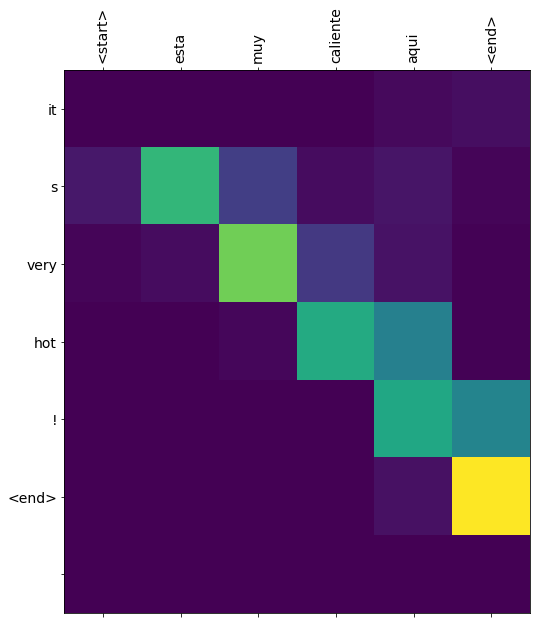

In [31]:
translate(u'Está muy caliente aquí')

Entrada: <start> asi es la vida . <end>
Traducción: that s life . <end> 


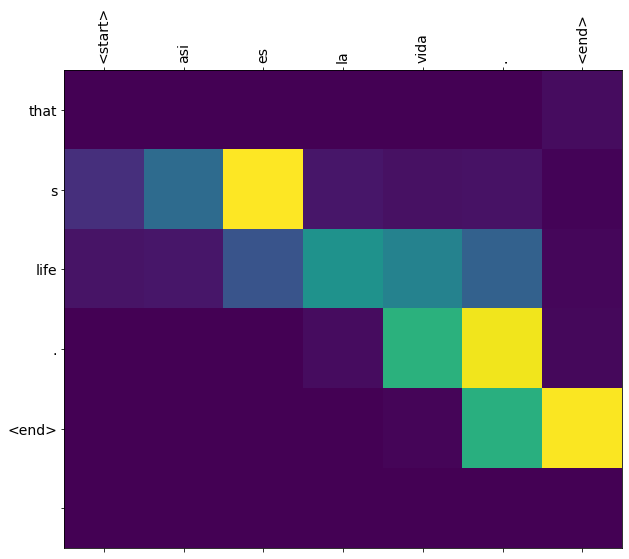

In [32]:
translate(u'Así es la vida.')

Entrada: <start> mi vida esta lleno de rosas <end>
Traducción: my life is full east . <end> 


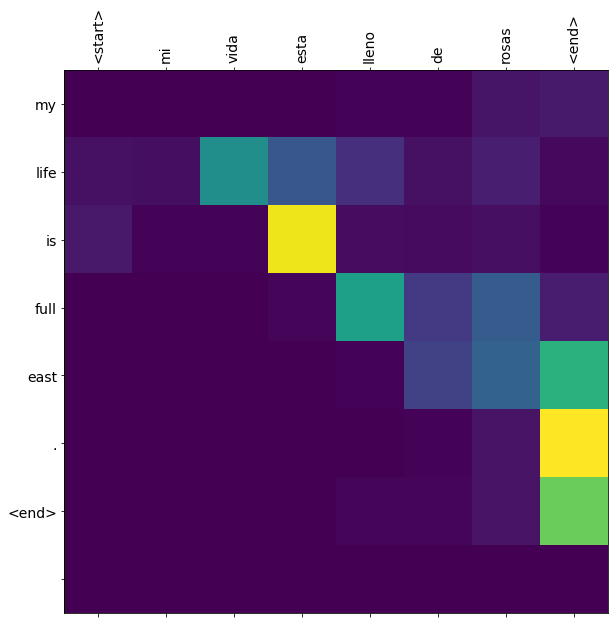

In [33]:
translate(u'Mi vida esta lleno de rosas')

Entrada: <start> la manana es bonita <end>
Traducción: tomorrow is incredible ! <end> 


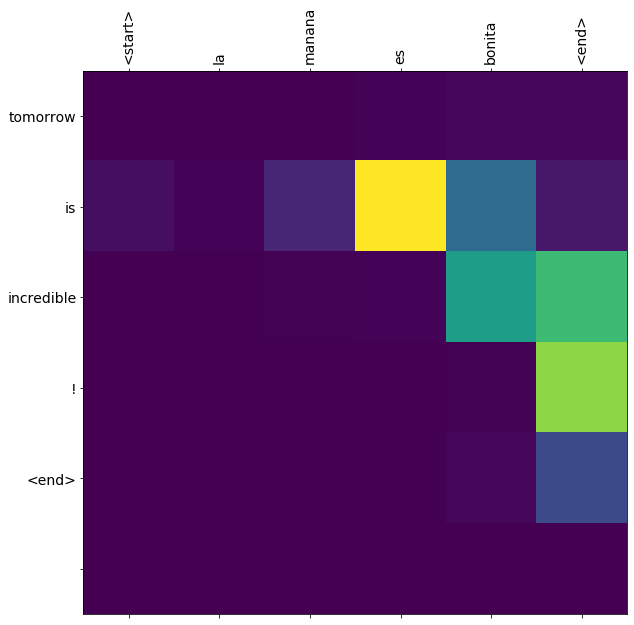

In [34]:
translate('la mañana es bonita')

Entrada: <start> la vida es corta <end>
Traducción: life is short . <end> 


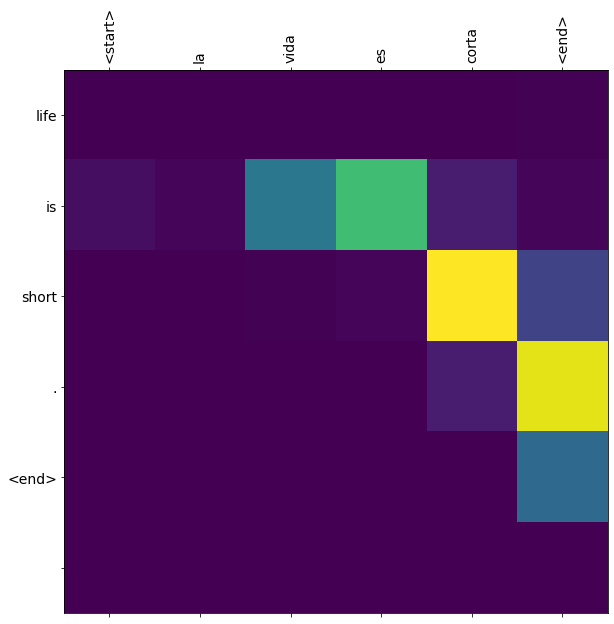

In [37]:
translate('La vida es corta')

Entrada: <start> muero lentamente cada amanecer <end>
Traducción: stop slowly . <end> 


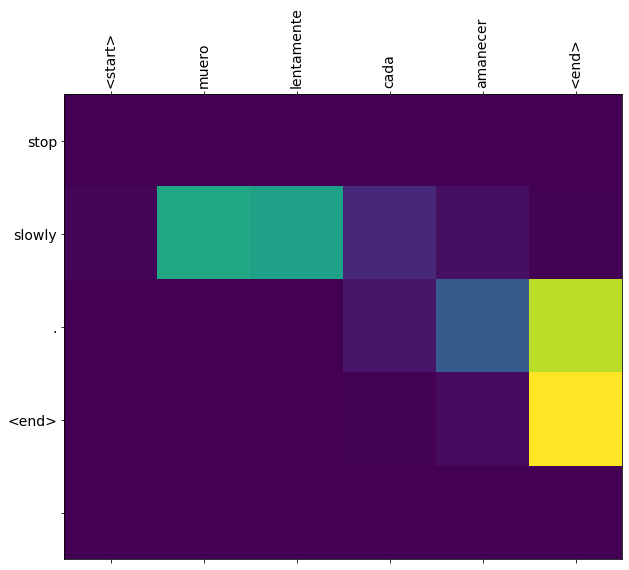

In [40]:
translate('Muero lentamente cada amanecer')

Como se ve, el traductor aun es muy limitado...el modelo se entrenó con pocos datos y para oraciones muy cortas.